# Ray start/stop

In [ ]:
ray.init(ignore_reinit_error=True)

In [ ]:
import ray
ray.shutdown()

# Imports

In [9]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
pd.set_option('float_format', '{:f}'.format)
pd.set_option('display.max_rows', 70)
pd.set_option('display.max_columns', 99)
import pandas_bokeh
pandas_bokeh.output_file("data/bokeh_output.html")

import polygon_df as pdf
import polygon_ds as pds
import polygon_s3 as ps3
import bar_samples as bs
import bar_labels as bl
import bar_workflow as bw
import utils_filters as ft
from utils_pickle import pickle_dump, pickle_load

import matplotlib as mpl
from matplotlib import style
style.use('fivethirtyeight')
mpl.rcParams['figure.figsize'] = [20, 7]

# df.style.background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)  # 'Blues', 'coolwarm', 'RdBu_r' & 'BrBG'
# pd.set_option('precision', 2)
# .plot_bokeh(sizing_mode="scale_height")
# set sampling params
symbol = 'VTI'
start_date = '2020-11-08'
end_date = '2020-11-09'
date = '2020-11-19'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
df = ps3.fetch_date_df(symbol, date, tick_type='trades')

VTI 2020-11-19 trying to get data from local file...


<AxesSubplot:>

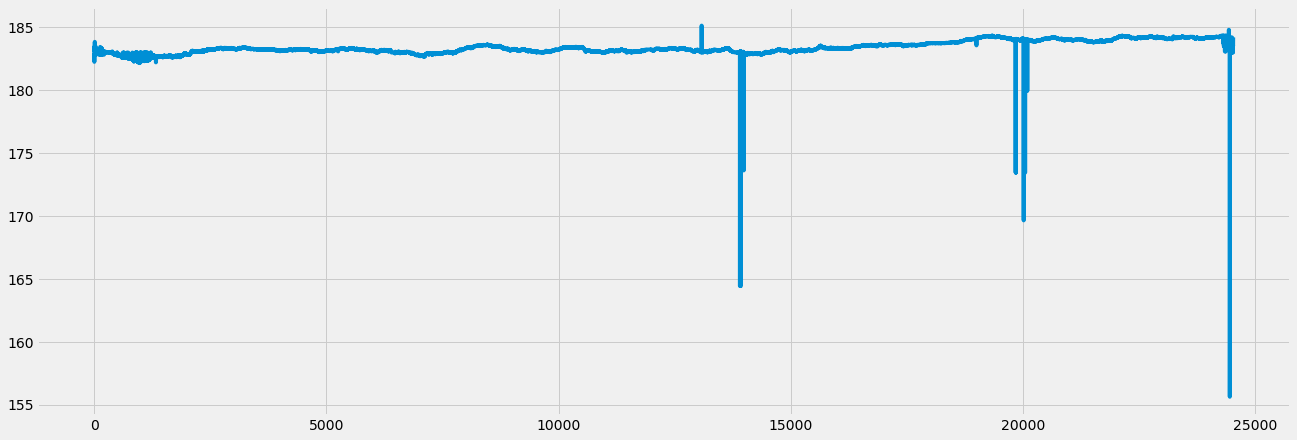

In [10]:
df.price.plot()

In [22]:
df.loc[:, 'cond_str'] = df.conditions.astype('string')

dfc = df[df.irregular==False]

dfc['price_diff'] = abs(dfc.price.diff())

<ipython-input-22-cb2dfb739add>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfc['price_diff'] = abs(dfc.price.diff())


In [23]:
dfc.price_diff.describe(percentiles=[.9, .99, .995])

count   24356.000000
mean        0.014097
std         0.172855
min         0.000000
50%         0.005005
90%         0.020004
99%         0.090012
99.5%       0.350006
max        14.425003
Name: price_diff, dtype: float64

<AxesSubplot:>

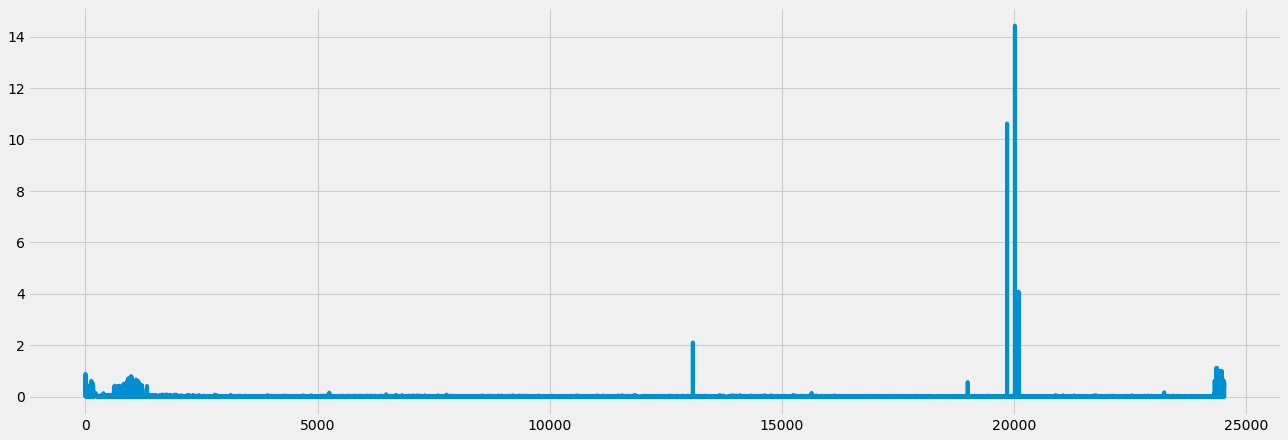

In [26]:
dfc.price_diff.plot()

<AxesSubplot:>

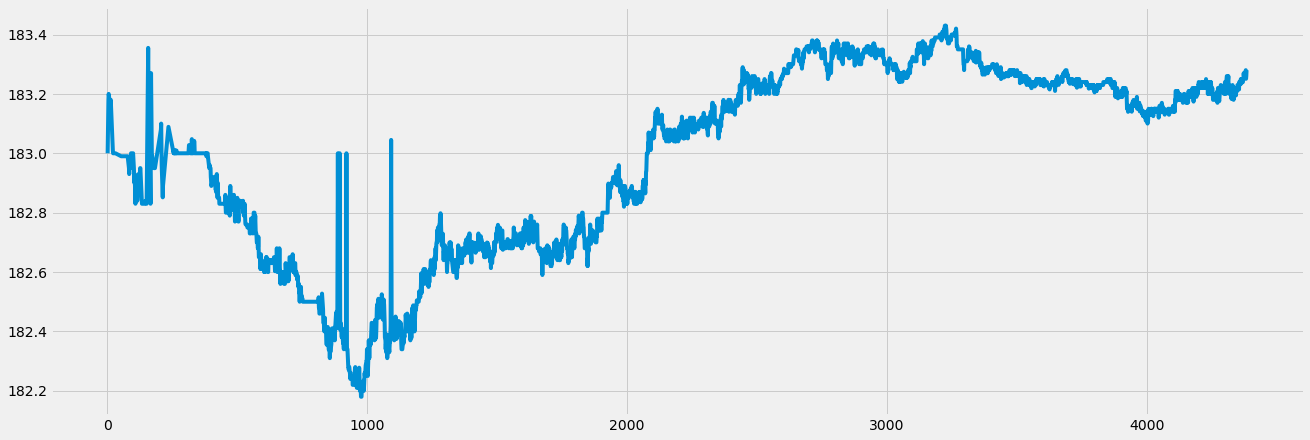

In [25]:
dfc[dfc.price_diff<.05].price[:4000].plot()

<AxesSubplot:>

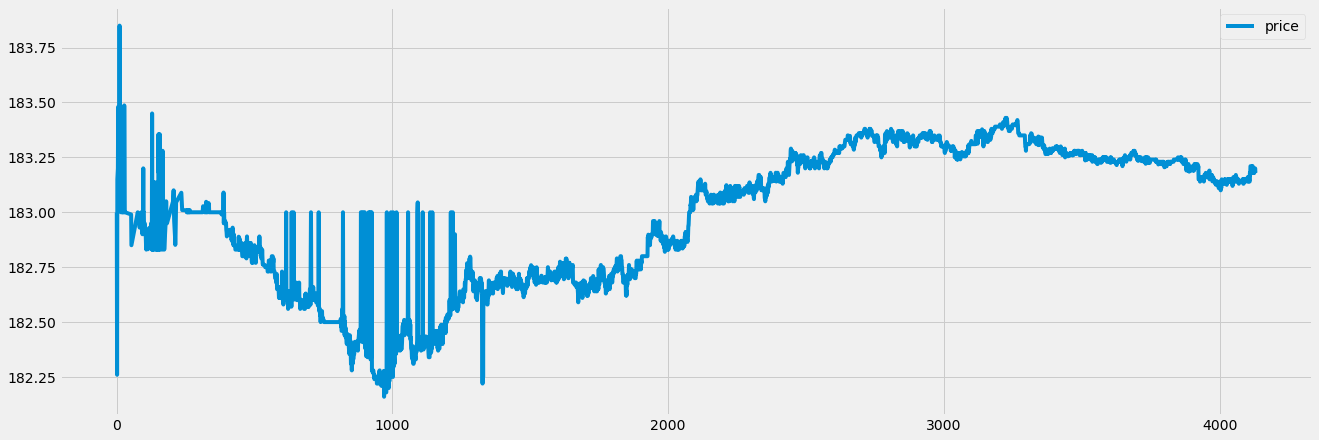

In [106]:
dfc[:4000].plot(y='price')

<AxesSubplot:>

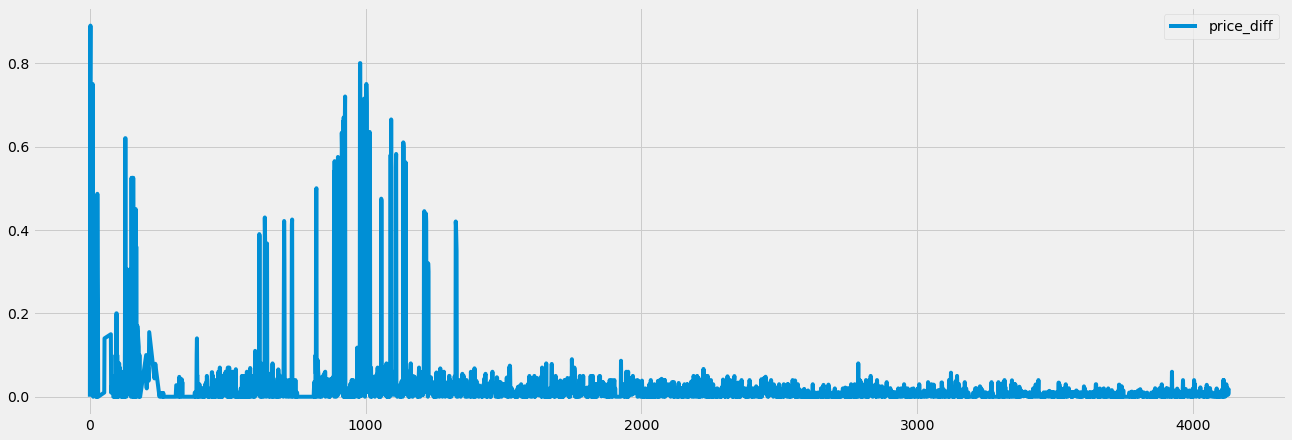

In [103]:
dfc[:4000].plot(y='price_diff')

# Sample tick dates

In [89]:
# set sampling params
symbol = 'VTI'
start_date = '2020-11-08'
end_date = '2020-11-09'
date = '2020-11-19'

thresh = {
    # max thresholds
    'renko_return': 'jma_return',
    'renko_reveral_multiple': 2,
    'renko_range_frac': 20,
    'max_duration_sec': 60*60*0.5,  # 1/2 hour
    # min thresholds
    'min_duration_sec': 10,
    'min_tick_count': 30,
    # label params
    'label_reward_ratios': list(np.arange(2, 11, 0.5)),
}

ray_on = True

if ray_on:
    import ray
    ray.init(ignore_reinit_error=True)


2021-01-05 21:45:58,301	INFO worker.py:666 -- Calling ray.init() again after it has already been called.


In [4]:
# bar_date_20201109 = bw.bar_dates_workflow(symbol, start_date, end_date, thresh, ray_on)

bar_dates = pickle_load('data/bar_dates.pkl')

In [16]:
stacked_df = bw.fill_gaps_dates(bar_dates, fill_col='jma_close')

stats_df = bw.bar_dates_stats(stacked_df)


In [5]:
results = []

for date in bar_dates:
    out = (date['ticks_df'].status.value_counts() / date['ticks_df'].shape[0]).to_dict()
    out.update({'date': date['date']})
    results.append(out)


In [13]:
pd.DataFrame(results).sort_values('outlier_filter', ascending=False)[:20] 

,clean,outlier_filter,timestamps_delta,irregular_condition,filter_warm_up,date,zero_volume
55,0.785880,0.206621,0.002652,0.004558,0.000290,2020-11-19,NaN
48,0.796642,0.197957,0.001740,0.003502,0.000158,2020-11-10,NaN
50,0.831976,0.162995,0.002971,0.001853,0.000206,2020-11-12,NaN
21,0.868783,0.122298,0.004330,0.004387,0.000202,2020-10-02,NaN
66,0.873366,0.120055,0.002977,0.003451,0.000151,2020-12-07,NaN
59,0.901428,0.091885,0.002346,0.004135,0.000205,2020-11-25,NaN
47,0.906994,0.082056,0.005197,0.005619,0.000134,2020-11-09,NaN
10,0.913155,0.082034,0.003537,0.001075,0.000198,2020-09-17,NaN
3,0.929368,0.063476,0.004305,0.002715,0.000136,2020-09-08,NaN
15,0.936334,0.058273,0.003357,0.001843,0.000193,2020-09-24,NaN


<AxesSubplot:xlabel='date'>

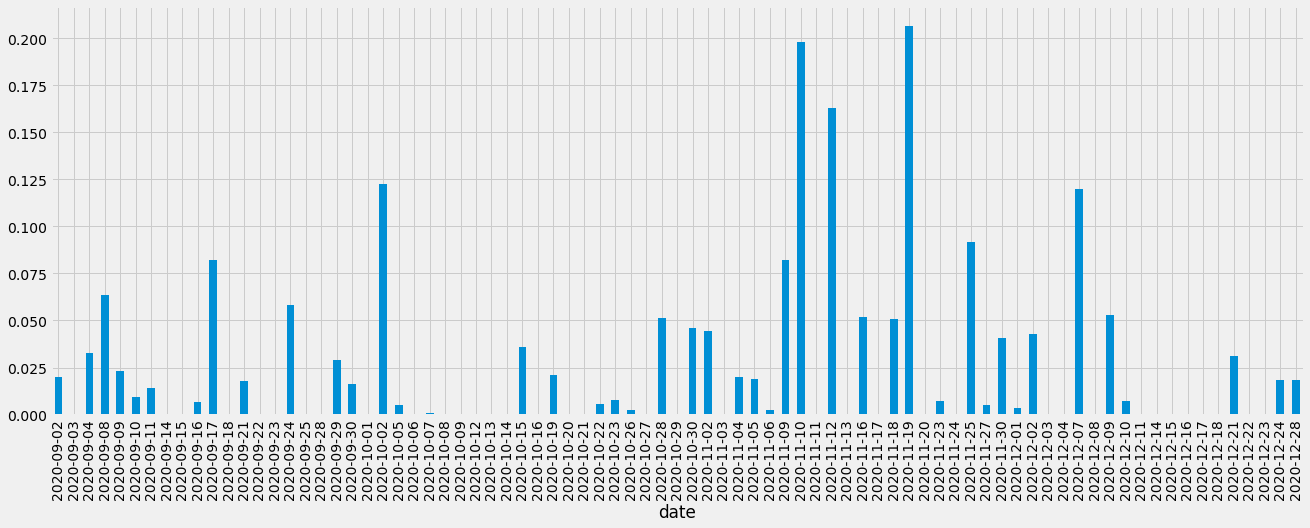

In [9]:
pd.DataFrame(results).set_index('date').outlier_filter.plot.bar()

In [12]:
pd.DataFrame(results).describe(percentiles=[.9,.95,.99])

,clean,outlier_filter,timestamps_delta,irregular_condition,filter_warm_up,zero_volume
count,81.000000,73.000000,81.000000,81.000000,81.000000,2.000000
mean,0.969149,0.026745,0.002900,0.003637,0.000208,0.000105
std,0.042759,0.044307,0.001078,0.001286,0.000063,0.000008
min,0.785880,0.000025,0.001374,0.001075,0.000084,0.000099
50%,0.988232,0.006863,0.002601,0.003517,0.000200,0.000105
90%,0.994315,0.078322,0.004291,0.005310,0.000296,0.000109
95%,0.995161,0.120952,0.004342,0.005756,0.000337,0.000110
99%,0.996385,0.200383,0.006165,0.006989,0.000356,0.000110
max,0.996530,0.206621,0.007897,0.007412,0.000387,0.000111


In [165]:
tdf = bar_date_20201109[0]['ticks_df'].set_index('nyc_dt')

tdf.loc[tdf.irregular==False, 'price_diff'] = tdf[tdf.irregular==False].price.diff()


<AxesSubplot:xlabel='nyc_dt'>

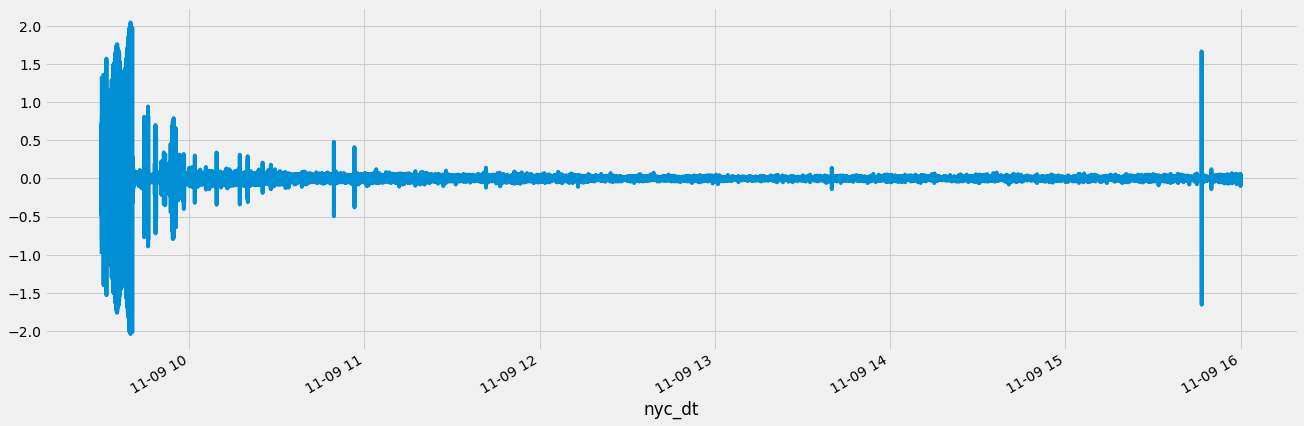

In [169]:
tdf.price_diff.plot()

<AxesSubplot:>

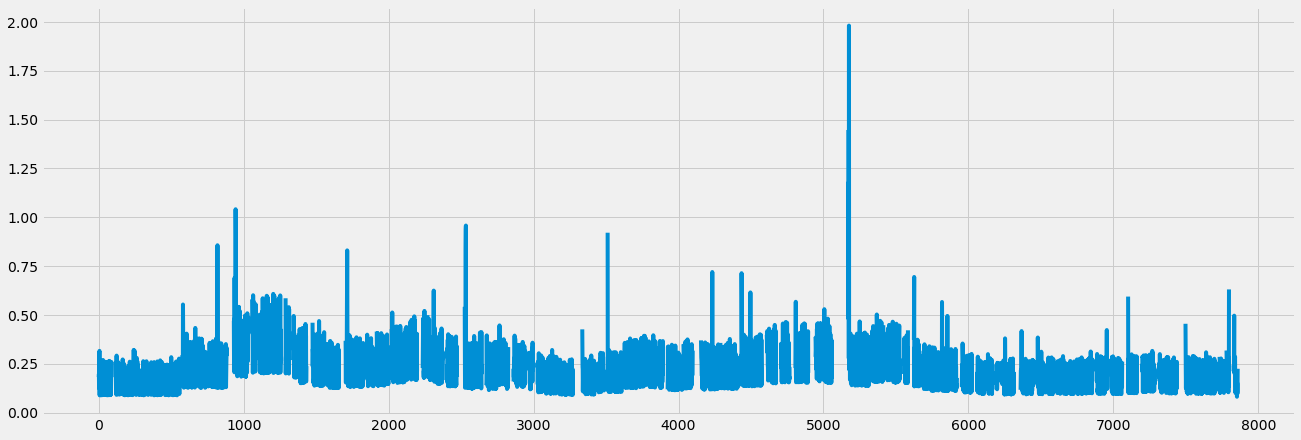

In [179]:
stacked_df.jma_range.plot()

<AxesSubplot:>

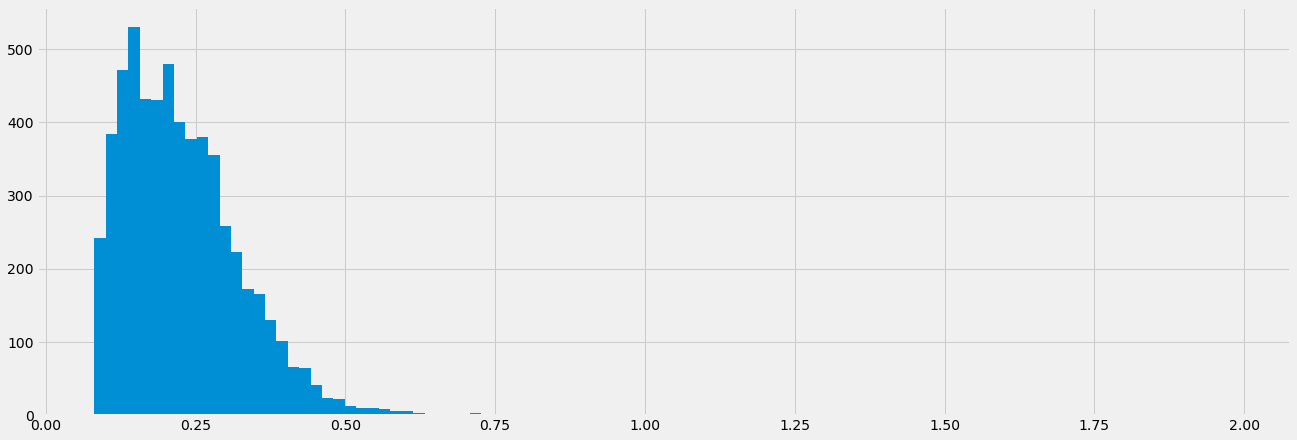

In [176]:
stacked_df.jma_range.hist(bins=100)

In [110]:
stacked_df[stacked_df.jma_range > .7].sort_values('close_at')

,bar_trigger,open_at,close_at,duration_td,duration_sec,duration_min,price_open,price_close,price_low,price_high,price_range,price_return,price_wq10,price_wq50,price_wq90,price_wq_range,price_wmean,price_wstd,jma_open,jma_close,jma_low,jma_high,jma_range,jma_return,jma_wq10,jma_wq50,jma_wq90,jma_wq_range,jma_wmean,jma_wstd,tick_count,volume,dollars,tick_imbalance,volume_imbalance,dollar_imbalance,label_side,label_outcome,label_rrr,label_outcome_at,label_start_at,label_end_at
819,renko_up,2020-09-04 13:48:54.440633600-04:00,2020-09-04 14:00:51.050398720-04:00,0 days 00:11:56.609765120,716.000000,11.933333,172.239807,172.380005,171.500000,172.380005,0.880005,0.140198,172.130005,172.220001,172.250000,0.119995,172.193367,0.053316,172.226602,172.360302,171.503491,172.360302,0.856810,0.133700,172.128195,172.217534,172.250000,0.121805,172.194546,0.050701,293.000000,44255.000000,7620417.451996,-45.000000,-23764.000000,-4091524.654785,short,profit,-3.500000,2020-09-04 14:14:52.545611264-04:00,2020-09-04 14:00:51.050398720-04:00,2020-09-04 14:30:51.050398720-04:00
944,renko_up,2020-09-08 09:43:01.523230208-04:00,2020-09-08 09:44:47.451784704-04:00,0 days 00:01:45.928554496,105.000000,1.750000,168.919998,170.009003,168.919998,170.009003,1.089005,1.089005,169.009995,169.020004,169.080994,0.070999,169.034879,0.038007,168.926416,169.961371,168.920166,169.961371,1.041205,1.034955,169.021882,169.028698,169.082956,0.061074,169.037346,0.035584,90.000000,9767.000000,1650963.660461,15.000000,-3018.000000,-510006.840866,neutral,neutral,0.000000,2020-09-08 09:51:59.594402560-04:00,2020-09-08 09:44:47.451784704-04:00,2020-09-08 10:14:47.451784704-04:00
945,renko_down,2020-09-08 09:48:14.039517440-04:00,2020-09-08 09:52:12.048670208-04:00,0 days 00:03:58.009152768,238.000000,3.966667,169.835007,169.125000,169.125000,170.149994,1.024994,-0.710007,169.210007,169.270004,169.276596,0.066589,169.266242,0.059770,169.954788,169.151265,169.151265,170.060001,0.908736,-0.803522,169.234706,169.264248,169.288299,0.053593,169.269448,0.057760,30.000000,942.000000,159448.800385,-15.000000,-365.000000,-61784.719345,long,profit,8.000000,2020-09-08 10:14:50.924385024-04:00,2020-09-08 09:52:12.048670208-04:00,2020-09-08 10:22:12.048670208-04:00
1713,renko_down,2020-09-21 09:37:21.593292032-04:00,2020-09-21 09:37:36.654604544-04:00,0 days 00:00:15.061312512,15.000000,0.250000,166.470001,165.672699,165.672699,166.470001,0.797302,-0.797302,165.699997,165.699997,165.710007,0.010010,165.703107,0.035816,166.408283,165.684277,165.684277,166.408283,0.724006,-0.724006,165.699997,165.699998,165.720056,0.020059,165.705803,0.038256,30.000000,703.000000,116489.284134,-27.000000,-686.000000,-113671.374191,long,profit,6.000000,2020-09-21 10:00:57.655045632-04:00,2020-09-21 09:37:36.654604544-04:00,2020-09-21 10:07:36.654604544-04:00
1714,renko_up,2020-09-21 09:37:36.758827520-04:00,2020-09-21 09:40:46.628187904-04:00,0 days 00:03:09.869360384,189.000000,3.150000,165.690002,166.470001,165.550003,166.470001,0.919998,0.779999,165.550003,165.601105,165.669998,0.119995,165.612786,0.041514,165.684300,166.387207,165.556685,166.387207,0.830522,0.702907,165.557890,165.610702,165.673230,0.115340,165.616203,0.039949,201.000000,22393.000000,3708567.125519,-36.000000,-9443.000000,-1563658.246857,long,profit,6.000000,2020-09-21 09:58:40.702826496-04:00,2020-09-21 09:40:46.628187904-04:00,2020-09-21 10:10:46.628187904-04:00
2531,renko_down,2020-10-02 09:34:10.462596096-04:00,2020-10-02 09:34:45.421691648-04:00,0 days 00:00:34.959095552,34.000000,0.566667,169.434998,168.649994,168.649994,169.490005,0.840012,-0.785004,169.429993,169.470001,169.479996,0.050003,169.452383,0.049339,169.434697,168.681440,168.650002,169.479606,0.829603,-0.753257,169.431851,169.463203,169.476044,0.044193,169.452040,0.045465,30.000000,1939.000000,328568.170364,-11.000000,-489.000000,-82849.475174,long,profit,10.500000,2020-10-02 09:40:12.843548928-04:00,2020-10-02 09:34:45.421691648-04:00,2020-10-02 10:04:45.421691648-04:00


<AxesSubplot:xlabel='date'>

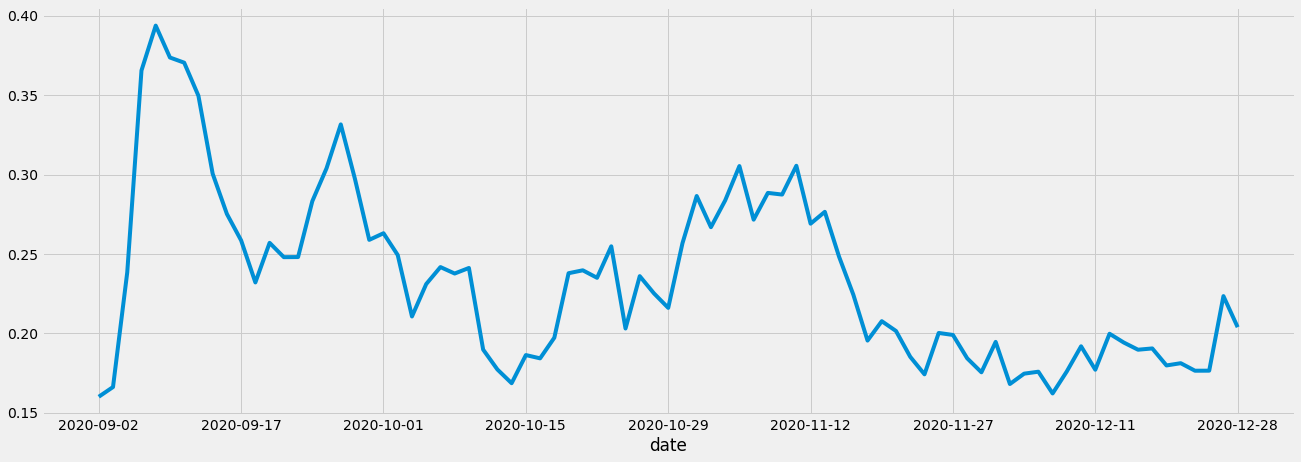

In [183]:
stats_df.set_index('date').jma_range_mean.plot()

<AxesSubplot:xlabel='date'>

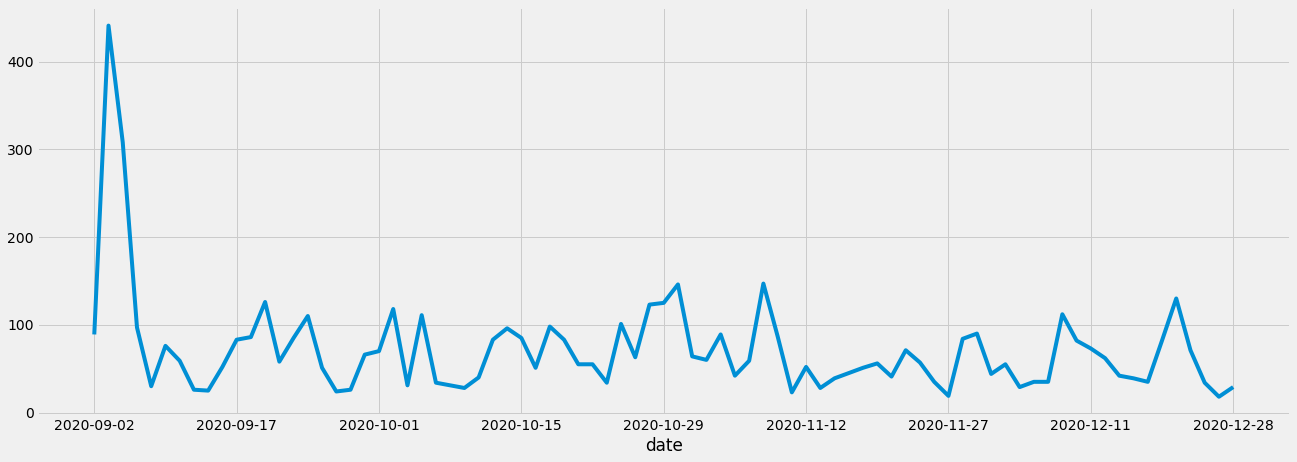

In [184]:
stats_df.set_index('date').bar_count.plot()

In [178]:
stats_df[stats_df.bar_count == stats_df.bar_count.max()]

,date,bar_count,duration_min_median,jma_range_mean,first_bar_open,last_bar_close
1,2020-09-03,441,0.533333,0.166202,2020-09-03 09:30:00.309262848-04:00,2020-09-03 15:58:09.932857600-04:00


In [ ]:
n = 10

pd.DataFrame(bar_dates[n]['ticks_df']).status.value_counts() / bar_dates[n]['ticks_df'].shape[0]

In [ ]:
df = pd.DataFrame(bar_dates[n]['bars'])

df[df.bar_trigger != 'gap_filler'][['jma_close','jma_high','jma_low']].plot()

In [ ]:
df[df.bar_trigger != 'gap_filler'].label_rrr.plot()

In [ ]:
df[df.bar_trigger != 'gap_filler'][['jma_wmean','jma_high','jma_low']].plot()

In [ ]:
df[df.bar_trigger != 'gap_filler'][['jma_wq10','jma_wq90']].plot()

In [ ]:
stacked_df.duration_min.describe(percentiles=[.1,.2,.9,.95])